# Beamlet free optimization

This example will present the basis of beamlet optimization with the OpenTPS core.

In [1]:
#imports 

import numpy as np

from matplotlib import pyplot as plt

from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.data.plan import FidObjective
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D

19/07/2023 03:52:49 PM - root - INFO - Loading logging configuration: /home/eliot/opentps/opentps_core/opentps/core/config/logger/logging_config.json
19/07/2023 03:52:49 PM - opentps.core._loggingConfig - INFO - Log level set: INFO
19/07/2023 03:52:50 PM - opentps.core.processing.imageProcessing.cupyImageProcessing - WARNING - Cannot import Cupy module
19/07/2023 03:52:50 PM - opentps.core.processing.registration.registrationMorphons - WARNING - cupy not found.
19/07/2023 03:52:50 PM - opentps.core.processing.C_libraries.libInterp3_wrapper - WARNING - cupy not found.


## Generic CT creation

We will first create a generic CT of a box filled with water and air

In [2]:
#calibratioin of the CT
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

#creation of the patient object
patient = Patient()
patient.name = 'Patient'

#size of the 3D box
ctSize = 150

#creation of the CTImage object
ct = CTImage()
ct.name = 'CT'
ct.patient = patient

huAir = -1024. #Hounsfield unit of water
huWater = ctCalibration.convertRSP2HU(1.) #convert a stopping power of 1. to HU units
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data #the CT generic image is created

## Region of interest

We will now create a region of interest wich is a small 3D box of size 20\*20\*20

In [3]:
roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[100:120, 100:120, 100:120] = True
roi.imageArray = data

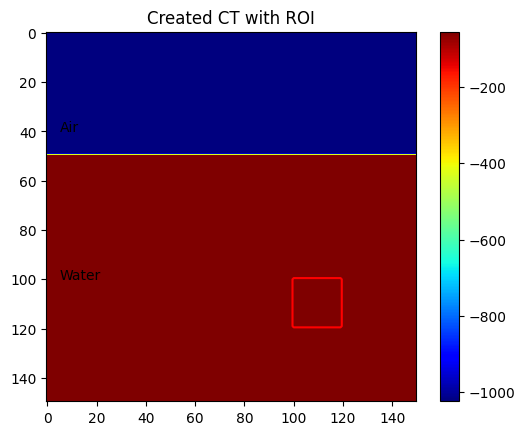

In [4]:
image = plt.imshow(ct.imageArray[110,:,:],cmap='jet')
plt.colorbar(image)
plt.contour(roi.imageArray[110,:,:],colors="red")
plt.title("Created CT with ROI")
plt.text(5,40,"Air")
plt.text(5,100,"Water")
plt.show()

## Configuration of MCsquare

To configure the MCsquare calculator we need to calibrate it with the CT calibration obtained above

In [5]:
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.ctCalibration = ctCalibration
mc2.nbPrimaries = 1e7

## Plan creation and design

We will now create a plan and set objectives for the optimization and set a goal of 20 Gy to the target

In [6]:
# Design plan
beamNames = ["Beam1"]
gantryAngles = [0.]
couchAngles = [0.]

# Generate new plan
planDesign = PlanDesign() #create a new plan
planDesign.ct = ct
planDesign.targetMask = roi
planDesign.gantryAngles = gantryAngles
planDesign.beamNames = beamNames
planDesign.couchAngles = couchAngles
planDesign.calibration = ctCalibration
planDesign.spotSpacing = 5.0
planDesign.layerSpacing = 5.0
planDesign.targetMargin = 5.0

plan = planDesign.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"


plan.planDesign.objectives = ObjectivesList() #create a new objective set
plan.planDesign.objectives.setTarget(roi.name, 20.0) #setting a target of 20 Gy for the target
plan.planDesign.objectives.fidObjList = []
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.0, 1.0)
plan.planDesign.defineTargetMaskAndPrescription()

19/07/2023 03:53:28 PM - opentps.core.data.plan._planDesign - INFO - Building plan ...
19/07/2023 03:53:28 PM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 5.0 mm. This process might take some time.
19/07/2023 03:53:28 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
19/07/2023 03:53:30 PM - opentps.core.data.plan._planDesign - INFO - New plan created in 2.0732057094573975 sec
19/07/2023 03:53:30 PM - opentps.core.data.plan._planDesign - INFO - Number of spots: 317


## MCsquare beamlet free planOptimization

Now that we have every needed object defined we can compute the optimization through MCsquare.
/!\ It may take some time to compute

In [7]:
doseImage = mc2.optimizeBeamletFree(ct, plan, [roi])

19/07/2023 03:53:46 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
19/07/2023 03:53:46 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
19/07/2023 03:53:47 PM - opentps.core.io.mcsquareIO - INFO - Write plan objectives: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/PlanObjectives.txt
19/07/2023 03:53:47 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/structs/TV.mhd
19/07/2023 03:53:47 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare_opti: 7: [: Linux: unexpected operator



Loaded structures:

Struct 0:
Name: TV
Mask GridSize: 150 150 150
Mask VoxelLength: 0.100000 0.100000 0.100000 (cm)
Mask Origin: 0.000000 0.000000 0.000000 (cm)
Number voxels inside mask: 8000


Target ROI ID: 0
Target ROI name: TV
Target dose prescription: 20.00 Gy

Objective 0:
ROI ID: 0
ROI Name: TV
Objective weight: 1.00
Objective type: 2 (Dmax)
Condition: 1 (less than)
Limit value: 20.00

Objective 1:
ROI ID: 0
ROI Name: TV
Objective weight: 1.00
Objective type: 1 (Dmin)
Condition: 2 (greater than)
Limit value: 20.00


Initialization time: 0.616430 s 


Simulation started (2023-07-19 15:53:48) 
1.27 % 
2.51 % 
3.77 % 
4.99 % 
6.24 % 
7.49 % 
8.75 % 
10.02 % 
11.28 % 
12.57 % 
13.85 % 
15.13 % 
16.42 % 
17.68 % 
18.96 % 
20.24 % 
21.52 % 
22.79 % 
24.07 % 
25.34 % 
26.63 % 
27.94 % 
29.26 % 
30.57 % 
31.89 % 
33.20 % 
34.52 % 
35.85 % 
37.17 % 
38.48 % 
39.70 % 
40.94 % 
42.19 % 
43.43 % 
44.67 % 
45.88 % 
47.13 % 
48.38 % 
49.63 % 
50.84 % 
52.10 % 
53.30 % 
54.54 % 
55.79 % 
57.

## Dose volume histogram

In [1]:
target_DVH = DVH(roi, doseImage)
print('D95 = ' + str(target_DVH.D95) + ' Gy')
print('D5 = ' + str(target_DVH.D5) + ' Gy')
print('D5 - D95 =  {} Gy'.format(target_DVH.D5 - target_DVH.D95))

NameError: name 'DVH' is not defined

## Center of mass

Here we look at the part of the 3D CT image where "stuff is happening" by getting the CoM. We use the function resampleImage3DOnImage3D to the same array size for both images.

In [9]:
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)

19/07/2023 03:55:20 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.


## Plot of the dose

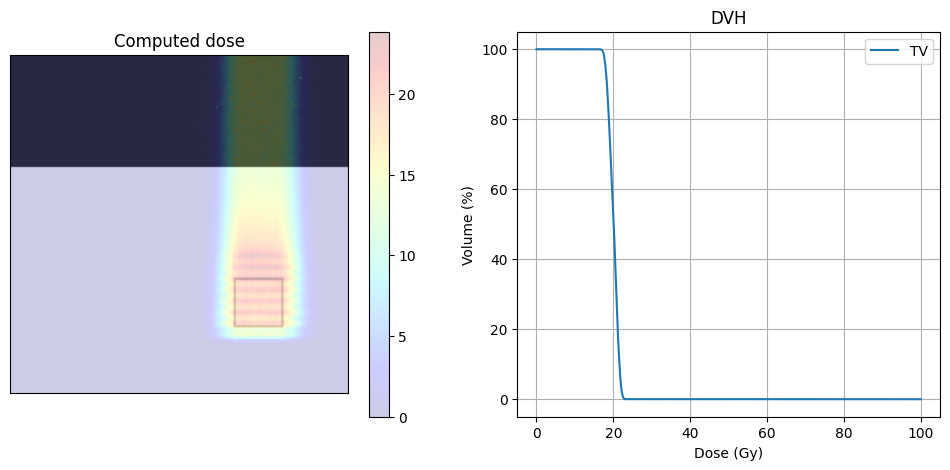

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
ax[0].set_title("Computed dose")
ax[1].set_title("DVH")
plt.grid(True)
plt.legend()

plt.show()